In [1]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

from matplotlib import pyplot as plt
SEED = 923984

In [2]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

# Loading and Preprocessing

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Regression : http://tseregression.org/ + https://arxiv.org/pdf/2012.02974

Prediction Datasets available :

* MackeyGlass
* Lorenz
* Sunspot

Classification Datasets available :

* Custom :  FSDD, HAART, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

In [3]:
import math
from scipy import sparse, stats
from datasets.load_forecasting import load_dataset_forecasting
from datasets.load_classification import load_dataset_classification

# Cross validation
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing

#Preprocessing
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data
from datasets.preprocessing import add_noise, duplicate_data
from datasets.load_data import load_data as load_dataset

# Define noise parameter
noise_std = 0.001

data_type = "normal" # "normal" ou "noisy"

def load_data(dataset_name, data_type, noise_std, step_ahead=5, visualize=False):
    (is_instances_classification, is_multivariate, sampling_rate,
     X_train_raw, X_test_raw, Y_train_raw, Y_test,
     use_spectral_representation, spectral_representation,
     groups) = load_dataset(dataset_name, step_ahead, visualize=False)
    
    WINDOW_LENGTH = 10
    freq_train_data = X_train_raw
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
        del X_train_raw, X_test_raw
        X_val_band = None
    else:
        X_test, X_train = X_test_raw, X_train_raw
        X_val, X_val_band = None, None
        del X_train_raw, X_test_raw
    Y_train = Y_train_raw
    del Y_train_raw
            
    # PREPROCESSING    
    freq_train_data = X_train_band if is_multivariate else X_train
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    
    if not is_multivariate:
        X_train_band = generate_multivariate_dataset(
            X_train, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        
        X_test_band = generate_multivariate_dataset(
            X_test, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    elif not use_spectral_representation:
        X_train_band = generate_multivariate_dataset(
            X_train_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        X_test_band = generate_multivariate_dataset(
            X_test_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    else:
        print("Data is already spectral and multivariate, nothing to do")
        
    scaler_multi = MinMaxScaler(feature_range=(0, 1))
    X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
                
    if not is_multivariate:
        scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
        X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       
    
    # NOISE
    if data_type == "noisy":
        if is_instances_classification:
            # UNI
            if not is_multivariate:
                X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN")]
                X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST")]
                
            # MULTI
            X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN")]
            X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST")]
        
        else:  #if prediction
            # UNI
            if not is_multivariate:
                X_train_noisy = add_noise(X_train, noise_std)
                X_test_noisy = add_noise(X_test, noise_std)
        
            # MULTI
            X_train_band_noisy = add_noise(X_train_band, noise_std)
            X_test_band_noisy = add_noise(X_test_band, noise_std)
    
    # Define the number of instances you want to select
    # Define the number of instances you want to select
    x_size = len(X_train_band) if is_multivariate else len(X_train)
    num_samples_for_pretrain = 500 if x_size >= 500 else x_size
    if is_instances_classification:
        indices = np.random.choice(x_size, num_samples_for_pretrain, replace=False)
    else:
        indices = range(x_size)
    
    
    if data_type == "noisy":
        # Defining pretrain   
        if not is_multivariate:
            X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices].flatten()
        X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]
    
    if not is_multivariate:
        X_pretrain = np.array(X_train, dtype=object)[indices].flatten()
    X_pretrain_band = np.array(X_train_band, dtype=object)[indices]

    return X_pretrain_band, X_train_band, X_test_band, Y_train, Y_test, is_multivariate, is_instances_classification

# Evaluation function

In [4]:
from scipy import stats
from numpy import random
import os


# Evaluating
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import (train_model_for_prediction, init_reservoir, init_ip_reservoir, init_local_rule_reservoir, 
                                                init_ip_local_rule_reservoir, init_readout)
from analysis.richness import spectral_radius, pearson, squared_uncoupled_dynamics_alternative, condition_number
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm

nb_jobs = 10
def evaluate_dataset_on_test(study, dataset_name, function_name, pretrain_data, train_data, test_data, Y_train, Y_test, is_instances_classification, nb_trials = 8, record_metrics=False):
    # Collect all hyperparameters in a dictionary
    hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
    print(hyperparams)
    leaky_rate = 1
    input_connectivity = 1

    # score for prediction
    if dataset_name == "Sunspot":
        start_step = 30
        end_step = 500
    else:
        start_step = 500
        end_step = 1500
    SLICE_RANGE = slice(start_step, end_step)

    if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
        hyperparams['variance_target'] = hyperparams['min_variance']
    if not is_instances_classification:
        hyperparams['use_full_instance'] = False

    RIDGE_COEF = 10**hyperparams['ridge']
    
    if function_name in ["hadsp", "desp"]:
        MAX_TIME_INCREMENT = hyperparams['time_increment'] + hyperparams['time_increment_span'] #int(max_window_size) or None or TIME_INCREMENT
    
    scores = [] 
    if record_metrics:
        spectral_radii = []
        pearson_correlations = []
        CEVs = []
        CNs = []
    for i in range(nb_trials):
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(hyperparams['network_size'] / common_size)
        n = common_size * K
    
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ei":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(-1, 1), seed=random.randint(0, 1000))
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'] ,  K, seed=random.randint(0, 1000))
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                     hyperparams['target_rate'], hyperparams['rate_spread'], function_name, is_instance=is_instances_classification, use_full_instance=hyperparams['use_full_instance'],
                                     max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method="pearson", n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                    hyperparams['variance_target'], hyperparams['variance_spread'], function_name, is_instance=is_instances_classification, 
                                    use_full_instance = hyperparams['use_full_instance'], max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method = "pearson", 
                                    intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], n_jobs = nb_jobs)
        elif function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja", "ip-anti-oja"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
        else:
            raise ValueError(f"Invalid function: {function_name}")
        
        # unsupervised local rules
        if is_instances_classification:
            unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
        else:
            unsupervised_pretrain = pretrain_data.astype(float)
        if function_name == "ip_correct":
            reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                          )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "anti_oja":
            reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                   synapse_normalization=True, bcm_theta=None,
                                                   leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                   )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "ip-anti-oja":
            reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                      synapse_normalization=True, bcm_theta=None,
                                                      mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                      leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                      )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        else:
            reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)
        readout = init_readout(ridge_coef=RIDGE_COEF)

        
        # TRAINING and EVALUATION
        if is_instances_classification:
            mode = "sequence-to-vector"
            train_model_for_classification(reservoir, readout, train_data, Y_train, n_jobs = nb_jobs, mode=mode)

            Y_pred = predict_model_for_classification(reservoir, readout, test_data, n_jobs = nb_jobs, mode=mode)
            score = compute_score(Y_pred, Y_test, is_instances_classification)
        else:
            esn = train_model_for_prediction(reservoir, readout, train_data, Y_train, warmup=start_step)
            
            Y_pred =  esn.run(test_data, reset=False)
            score = compute_score(Y_pred[SLICE_RANGE], Y_test[SLICE_RANGE], is_instances_classification)

        scores.append(score)
        if record_metrics:
            states_history_multi = []
            neurons_state = np.random.uniform(0, 1, bias.size)
            inputs = np.concatenate(test_data, axis=0) if is_instances_classification else test_data
            states_history_multi = reservoir.run(inputs)
            
            sr = spectral_radius(W)
            pearson_correlation, _ = pearson(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)
            CEV = squared_uncoupled_dynamics_alternative(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)

            spectral_radii.append(sr)
            pearson_correlations.append(pearson_correlation[0])
            CEVs.append(CEV[0])
            #CNs.append(CN[0])

    if record_metrics:
        return scores, spectral_radii, pearson_correlations, CEVs
    return scores


# Common visualisation definitions

In [5]:
from seaborn import color_palette

# -- Define color palettes for each group --
blues = color_palette("Blues", 3)      # 3 shades of blue
oranges = color_palette("Oranges", 2)  # 2 shades of orange
greens = color_palette("Greens", 2)    # 2 shades of green

# -- Map each function to its color --
function_colors = {
    'E-ESN':              greens[0],
    'ESN':                greens[1],
    'IP':                 blues[0],
    'Anti-Oja':           blues[1],
    'IP +\nAnti-Oja':     blues[2],
    'mean HAG':           oranges[0],
    'variance HAG':       oranges[1],
}

# If you want a specific order for the bars, you can enforce it:
functions_order = [
    'E-ESN',
    'ESN', 
    'IP', 
    'Anti-Oja', 
    'IP +\nAnti-Oja', 
    'mean HAG', 
    'variance HAG', 
]

function_mapping = {
    'ip-anti-oja': 'IP +\nAnti-Oja',
    'ip_correct':  'IP',
    'anti-oja':    'Anti-Oja',
    'desp':        'variance HAG',
    'hadsp':       'mean HAG',
    'random_ei':   'ESN',
    'random':      'E-ESN',
}

# HPO Comparaison

In [ ]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

# Read your CSV file (already containing TPE vs. CMA-ES results)
file_name = "outputs/hpo_strategy.csv"
df = pd.read_csv(file_name)

# --- 1) Basic Cleanup ---
# Remove '%' from "Average Score" so we can convert to float
df['Average Score'] = pd.to_numeric(
    df['Average Score'].str.replace('%', ''), 
    errors='coerce'
)
# Remove '±' and '%' from "Standard Deviation"
df['Standard Deviation'] = pd.to_numeric(
    df['Standard Deviation'].str.replace('±', '').str.replace('%', ''), 
    errors='coerce'
)


# Optionally remove an unwanted function
# df = df[df['Function'] != 'ip']

# Rename functions for your final labels
df['Function'] = df['Function'].replace(function_mapping)

# Optional replacements for dataset names
df['Dataset'] = df['Dataset'].replace({
    'JapaneseVowels':     'Japanese\nVowels',
})


# 2b) distinguish TPE vs CMA-ES by hatch pattern (or alpha, edgecolor, etc.)
sampler_hatching = {
    'tpe':   '',     # no hatch
    'cmaes': '///',  # diagonal hatch
}

# Filter to only those in the DataFrame
functions = [f for f in functions_order if f in df['Function'].unique()]

# If you also want an explicit order for Sampler
samplers = ['tpe', 'cmaes']

# --- 3) Build the grouped bar chart ---

datasets = df['Dataset'].unique()
datasets.sort()  # optional: sort datasets alphabetically
x = np.arange(len(datasets))  # label locations
width = 0.08                  # narrower bar for more sub-bars

fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 12

# Outer loop over functions
for i, func in enumerate(functions):
    # Inner loop over the two samplers
    for j, sampler in enumerate(samplers):
        # Horizontal offset for each bar
        # We have 2 samplers per function, so total sub-width = 2*width
        offset = i * (2 * width) + j * width

        # Extract rows for this function + sampler
        sub_df = df[(df['Function'] == func) & (df['Sampler'] == sampler)]

        # Merge with the dataset ordering to align bar positions
        merged = pd.DataFrame({'Dataset': datasets}).merge(sub_df, on='Dataset', how='left')

        # Plot the bars
        ax.bar(
            x + offset,
            merged['Average Score'],
            width,
            label=None,  # We'll manually handle legend
            yerr=merged['Standard Deviation'],
            capsize=4,
            color=function_colors.get(func, 'gray'),  # fallback color if missing
            hatch=sampler_hatching.get(sampler, ''),  # or '' if missing
            edgecolor='black'                         # optional to see the hatch better
        )

# --- 4) Cosmetic adjustments ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)

# X-axis label
ax.set_xlabel('Dataset', fontsize=fontsize)

# Y-axis label (change if classification vs. NRMSE)
# e.g., if your CSV is for classification, you might put "Classification Rate (%)"
ax.set_ylabel('Average Score', fontsize=fontsize)

# Position x-ticks in the center of each dataset group
total_functions = len(functions)
total_samplers = len(samplers)  # 2
group_width = total_functions * total_samplers * width
ax.set_xticks(x + group_width/2 - (width/2))
ax.set_xticklabels(datasets, rotation=0)

# --- 5) Build a custom legend ---
# 5a) Legend for the Functions (colors)
from matplotlib.patches import Patch

function_legend = [
    Patch(facecolor=function_colors[f], edgecolor='black', label=f) for f in functions
]

# 5b) Legend for the Samplers (hatching)
sampler_legend = [
    Patch(facecolor='white', edgecolor='black', hatch=sampler_hatching[s], 
          label=s.upper())  # or s.title()
    for s in samplers
]

# Combine them in one line, or do them separately
first_legend = ax.legend(handles=function_legend, title='Function', loc='upper left', fontsize=fontsize)
ax.add_artist(first_legend)  # explicitly add the first legend, then a second one
ax.legend(handles=sampler_legend, title='Sampler', loc='lower left', fontsize=fontsize)

plt.tight_layout()
plt.show()

# Test scores

In [ ]:
import numpy as np

from datetime import datetime

from performances.utility import retrieve_best_model

# Create an empty DataFrame to store the results
columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
variate_type = "multi"  # "multi" or "uni"

for dataset_name in ["SPEECHCOMMANDS"]: 
    new_results = pd.DataFrame(columns=columns)
    # Can be "MackeyGlass", "Lorenz", "Sunspot", "Henon", "NARMA", "CatsDogs", "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits", "Henon"
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset_name, data_type, noise_std, visualize=True)
    if is_instances_classification:
        file_name = "outputs/test_results_classification.csv"
    else: 
        file_name = "outputs/test_results_prediction.csv"
    print(dataset_name)
    # Simulate your data and loop for evaluation

    for function_name in ["ip_correct", "ip-anti-oja"]: # "random_ee", "random_ei", "ip_correct", "anti-oja",  "ip-anti-oja", "hadsp", "desp"
        print(function_name)
        study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal")
    
        scores = evaluate_dataset_on_test(
            study, 
            dataset_name,
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            record_metrics=False
        )
        # Compute the average and standard deviation of the scores
        average_score = np.mean(scores)
        std_deviation = np.std(scores)
    
        if is_instances_classification:
            formatted_average = f"{round(average_score * 100, 5)} %"
            formatted_std = f"± {round(std_deviation * 100, 5)} %"
        else:
            formatted_average = f"{round(average_score, 5)}"
            formatted_std = f"± {round(std_deviation, 5)}"
        
        # Capture the current date
        current_date = datetime.now().strftime('%Y-%m-%d')
        
        # Create a new DataFrame row with the Date column
        new_row = pd.DataFrame({
            'Dataset': [dataset_name],
            'Function': [function_name],
            'Average Score': [formatted_average],
            'Standard Deviation': [formatted_std],
            'Date': [current_date]
        })
        
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
    
    
    # Display the DataFrame
    print(new_results)
    
    # Load the existing CSV
    if os.path.exists(file_name):
        previous_results = pd.read_csv(file_name)
    else:
        columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
        print(f"{file_name} created successfully.")
        
    tots_results = pd.concat([new_results, previous_results], axis=0)
    
    tots_results.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}.")

## Visualisation

In [ ]:
import os
import pandas as pd 

file_name = "outputs/test_results_classification.csv"

if 'file_name' not in locals() and 'file_name' not in globals():
    file_name = "outputs/test_results_prediction.csv"  #  test_results_classification.csv or test_results_prediction.csv

if os.path.exists(file_name):
    previous_results = pd.read_csv(file_name)
else:
    # File does not exist, create it with the necessary columns
    columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
    previous_results = pd.DataFrame(columns=columns)
    # Save the empty DataFrame as a CSV
    previous_results.to_csv(file_name, index=False)
    print(f"{file_name} created successfully.")

print(f"Results saved to {file_name}.")
previous_results

In [ ]:
import pandas as pd
from seaborn import color_palette
from matplotlib import pyplot as plt
import numpy as np

all_results = pd.read_csv(file_name)
df = pd.DataFrame(all_results)

# Clean data as before
df['Average Score'] = df['Average Score'].astype(str).str.replace('%', '').astype(float)
df['Standard Deviation'] = df['Standard Deviation'].str.replace('±', '').str.replace('%', '').astype(float)

df = df[df['Function'] != 'ip']

df['Function'] = df['Function'].str.replace('ip-anti-oja', 'IP +\nAnti-Oja')
df['Function'] = df['Function'].str.replace('ip_correct', 'IP')
df['Function'] = df['Function'].str.replace('anti-oja', 'Anti-Oja')

df['Function'] = df['Function'].str.replace('desp', 'variance HAG')
df['Function'] = df['Function'].str.replace('hadsp', 'mean HAG')
df['Function'] = df['Function'].str.replace('random_ei', 'ESN')
df['Function'] = df['Function'].str.replace('random', 'E-ESN')

# Optional replacements for dataset names
#df = df[df['Dataset'].isin(["Lorenz", "MackeyGlass", "Sunspot"])]


if file_name == "outputs/test_results_classification.csv":
    df['Dataset'] = df['Dataset'].str.replace('SpokenArabicDigits', 'Spoken\nArabic\nDigits')
    df['Dataset'] = df['Dataset'].str.replace('SPEECHCOMMANDS', 'SPEECH\nCOMMANDS')
    df['Dataset'] = df['Dataset'].str.replace('JapaneseVowels', 'Japanese\nVowels')

# Filter out (or keep) only the functions actually present in df
functions = [f for f in functions_order if f in df['Function'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

datasets = df['Dataset'].unique()
x = np.arange(len(datasets))  # The label locations
width = 0.1                   # Width of each bar

for i, func in enumerate(functions):
    # Grab only rows for this function
    values = df[df['Function'] == func]
    
    # We create a Series in the same order as 'datasets'
    merged = pd.DataFrame({'Dataset': datasets}).merge(values, on='Dataset', how='left')
    
    ax.bar(
        x + i * width,
        merged['Average Score'],
        width,
        label=func,
        yerr=merged['Standard Deviation'],
        capsize=5,
        color=function_colors[func]
    )

fontsize = 14

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_yscale('log')
ax.set_xlabel('Dataset', size=fontsize)
if file_name == "outputs/test_results_prediction.csv":
    plt.ylabel('NRMSE', size=fontsize)
else:
    plt.ylabel('Classification Rate', size=fontsize)
plt.legend(title='Algorithm', fontsize=fontsize)

# Position x-ticks in the center of all the bars for each dataset
ax.set_xticks(x + width * (len(functions)-1)/2)
ax.set_xticklabels(datasets)

plt.tight_layout()
plt.show()

# Best parameters

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model


# List of datasets (extract from filenames)
datasets = [
    "SpokenArabicDigits",
    "JapaneseVowels",
    "FSDD",
    "SPEECHCOMMANDS",
    "CatsDogs",
    "MackeyGlass",
    "Lorenz",
    "Sunspot_daily",
]

# Initialize an empty list to store results
results = []

# Initialize an empty list to store results
results = []
function_name = "ip-anti-oja"
for dataset in datasets:
    study = retrieve_best_model(function_name, dataset, is_multivariate=True, variate_type = "multi", data_type = "normal")
    best_trial = study.best_trial
    results.append({
        "dataset": dataset,
        "function_name": function_name,
        **best_trial.params,
    })
# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv(f"outputs/best_hyperparameters_{function_name}.csv", index=False)

print(f"Results saved to best_hyperparameters_{function_name}.csv")


# Richness

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model

# Create an empty DataFrame to store the results
columns = [
    "dataset", 
    "function_name", 
    "spectral_radius_mean", 
    "spectral_radius_std", 
    "pearson_mean", 
    "pearson_std",
    "CEV_mean",
    "CEV_std",
    "scores_mean",
    "scores_std",
]

new_results = pd.DataFrame(columns=columns)

# List of datasets (extract from filenames)
datasets = [
#    "CatsDogs",
#    "JapaneseVowels",
#    "SpokenArabicDigits",
#    "FSDD",
    "SPEECHCOMMANDS",
#    "MackeyGlass",
#    "Lorenz",
#    "Sunspot_daily",
]



# Initialize an empty list to store results
results = []

for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std, visualize=False)
    for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja", "ip-anti-oja",  "hadsp", "desp"]:
        # Get the best trial from the study
        print(function_name)
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        
        scores, SRs, pearsons, CEVs = evaluate_dataset_on_test(
            study, 
            dataset,
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            nb_trials = 4,
            record_metrics=True
        )
        print(scores)
        # Create a new DataFrame row
        new_row = pd.DataFrame({
            "dataset": [dataset],
            "function_name": [function_name],
            "spectral_radius_mean": [np.mean(SRs)],
            "spectral_radius_std": [np.std(SRs)],
            "pearson_mean": [np.mean(pearsons)],
            "pearson_std": [np.std(pearsons)],
            "CEV_mean": [np.mean(CEVs)],
            "CEV_std": [np.std(CEVs)],
            "scores_mean": [np.mean(scores)],
            "scores_std": [np.std(scores)],
        })
    
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
        

# Display the DataFrame
print(new_results)
file_name = "metrics.csv"

# Load the existing CSV
if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
    try:
        previous_results = pd.read_csv(file_name)
    except pd.errors.EmptyDataError:
        print(f"{file_name} is empty. Initializing with default columns.")
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
else:
    print(f"{file_name} does not exist or is empty. Creating a new file.")
    previous_results = pd.DataFrame(columns=columns)
    previous_results.to_csv(file_name, index=False)
    
tots_results = pd.concat([new_results, previous_results], axis=0)

tots_results.to_csv(file_name, index=False)

print(f"Results saved to {file_name}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.ticker import MaxNLocator  # Importing here for completeness

# Load your data
file_name = 'metrics.csv'
data = pd.read_csv(file_name)

# Define the mapping from function_name to descriptive labels
function_mapping = {
    'random': 'E-ESN',
    'random_ei': 'ESN',
    'ip_correct': 'IP',
    'anti-oja': 'Anti-Oja',
    'ip-anti-oja': 'IP +\nAnti-Oja',
    'hadsp': 'mean HAG',      
    'desp': 'variance HAG'  
}

datasets = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
    "SPEECHCOMMANDS",
    "MackeyGlass",
    "Lorenz",
    "Sunspot_daily",
]


# Optional replacements for dataset names
data = data[data['dataset'].isin(datasets)]

# Apply the mapping to create a new column with descriptive labels
data['Algorithm'] = data['function_name'].map(function_mapping)

# Extract unique functions and datasets for plotting
functions = ['E-ESN', 'ESN', 'IP', 'Anti-Oja', 'IP +\nAnti-Oja', 'mean HAG', 'variance HAG'] #data['Algorithm'].unique()
datasets = data['dataset'].unique()

# Prepare color palette for the bars
colors = color_palette("tab20", n_colors=len(functions))
fontsize = 22

# Metrics to plot
metrics = ['spectral_radius_mean', 'pearson_mean', 'CEV_mean', 'scores_mean']
error_metrics = ['spectral_radius_std', 'pearson_std', 'CEV_std', 'scores_std']

# Iterate over each metric to create separate plots
for metric_index, metric in enumerate(metrics):
    plt.figure(figsize=(14, 8))  # New figure for each metric
    ax = plt.subplot(111)
    x = np.arange(len(datasets))  # The label locations
    width = 0.1
    
    
    for i, func in enumerate(functions):
        subset = data[data['Algorithm'] == func]
        means = subset[metric].values
        errors = subset[error_metrics[metric_index]].values
        ax.bar(
            np.arange(len(datasets)) + i * width,
            means,
            width,
            label=func,
            yerr=errors,
            capsize=5,
            color=function_colors[func],
            error_kw={'elinewidth': 2, 'capthick': 2}
        )


    # Set x-axis labels and ticks
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=fontsize)
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=fontsize)
    
    # Increase the number of y-axis ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed
    
    # Optionally, set y-axis limits based on your data
    # ax.set_ylim(0, Z100)  # Uncomment and adjust if necessary
    

    ax.set_xticks(x + width * (len(functions)-1)/2)

    ax.set_xticklabels(datasets, rotation=45, fontsize=fontsize)

    # Set legend with descriptive labels
    ax.legend(title='Algorithm', fontsize=fontsize, title_fontsize=fontsize)

    # Improve aesthetics by removing top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()

# Final matrix

In [6]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm
from scipy import sparse
import numpy as np
import math

# List of datasets
classification = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
    "SPEECHCOMMANDS",
]

prediction = [
    "MackeyGlass",
    "Lorenz",
    "Sunspot_daily",
]
datasets=prediction


# Initialize lists to store results and max values
Ws = []
titles = []
max_values = []

leaky_rate = 1
input_connectivity = 1

# Loop through datasets and function names to compute W matrices and find global vmax
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)

    for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja", "ip-anti-oja",  "hadsp", "desp"]:
        print(function_name)
        # Get the best trial from the study
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
        if function_name in ["hadsp", "desp"]:
            MAX_TIME_INCREMENT = hyperparams['time_increment'] + hyperparams['time_increment_span'] #int(max_window_size) or None or TIME_INCREMENT
    
        if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
            hyperparams['variance_target'] = hyperparams['min_variance']
        if not is_instances_classification:
            hyperparams['use_full_instance'] = False

        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(hyperparams["network_size"] / common_size)
        n = common_size * K
        
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ei":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(-1, 1), seed=random.randint(0, 1000))
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'] ,  K, seed=random.randint(0, 1000))
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                     hyperparams['target_rate'], hyperparams['rate_spread'], function_name, is_instance=is_instances_classification, use_full_instance=hyperparams['use_full_instance'],
                                     max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method="pearson", n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                    hyperparams['variance_target'], hyperparams['variance_spread'], function_name, is_instance=is_instances_classification, 
                                    use_full_instance = hyperparams['use_full_instance'], max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method = "pearson", 
                                    intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], n_jobs = nb_jobs)
        elif function_name in ["random_ee", "random_ei"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
            
        elif function_name in ["ip_correct", "anti-oja", "ip-anti-oja"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))

            # unsupervised local rules
            if is_instances_classification:
                unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
            else:
                unsupervised_pretrain = pretrain_data.astype(float)
            if function_name == "ip_correct":
                reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                              leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                              )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            elif function_name == "anti-oja":
                reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                       synapse_normalization=True, bcm_theta=None,
                                                       leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                       )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            elif function_name == "ip-anti-oja":
                reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                          synapse_normalization=True, bcm_theta=None,
                                                          mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                          )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            else:
                reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)

            W = reservoir.W
            

        # Store W matrix and corresponding title
        Ws.append(W)
        titles.append(f"{dataset} - {[function_name]}")
        max_values.append(np.max(W))


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MackeyGlass
random
random_ei
ip_correct
anti-oja
ip-anti-oja
hadsp


HAG algorithm: 100%|█████████▉| 14848/14885 [00:08<00:00, 1840.30it/s] 


desp


HAG algorithm: 100%|█████████▉| 14781/14840 [01:02<00:00, 236.29it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `seed`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Lorenz
random
random_ei
ip_correct
anti-oja
ip-anti-oja
hadsp


HAG algorithm: 100%|█████████▉| 14518/14580 [00:07<00:00, 2024.35it/s] 


desp


HAG algorithm:  99%|█████████▉| 14401/14500 [00:25<00:00, 554.82it/s]


Sunspot_daily
random
random_ei
ip_correct
anti-oja
ip-anti-oja
hadsp


HAG algorithm: 100%|█████████▉| 66071/66217 [01:07<00:00, 975.57it/s]  


desp


HAG algorithm: 100%|█████████▉| 66444/66462 [11:56<00:00, 92.67it/s] 


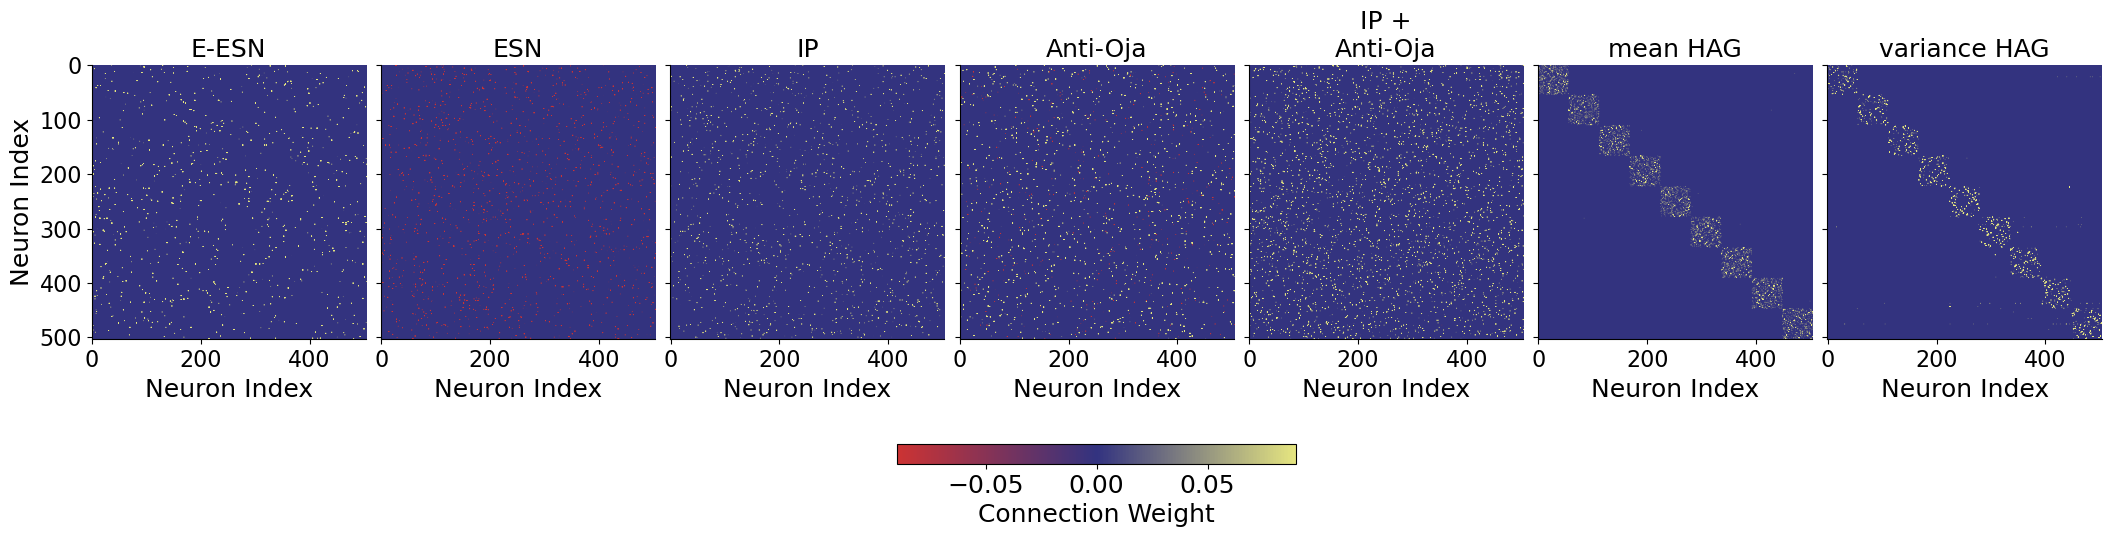

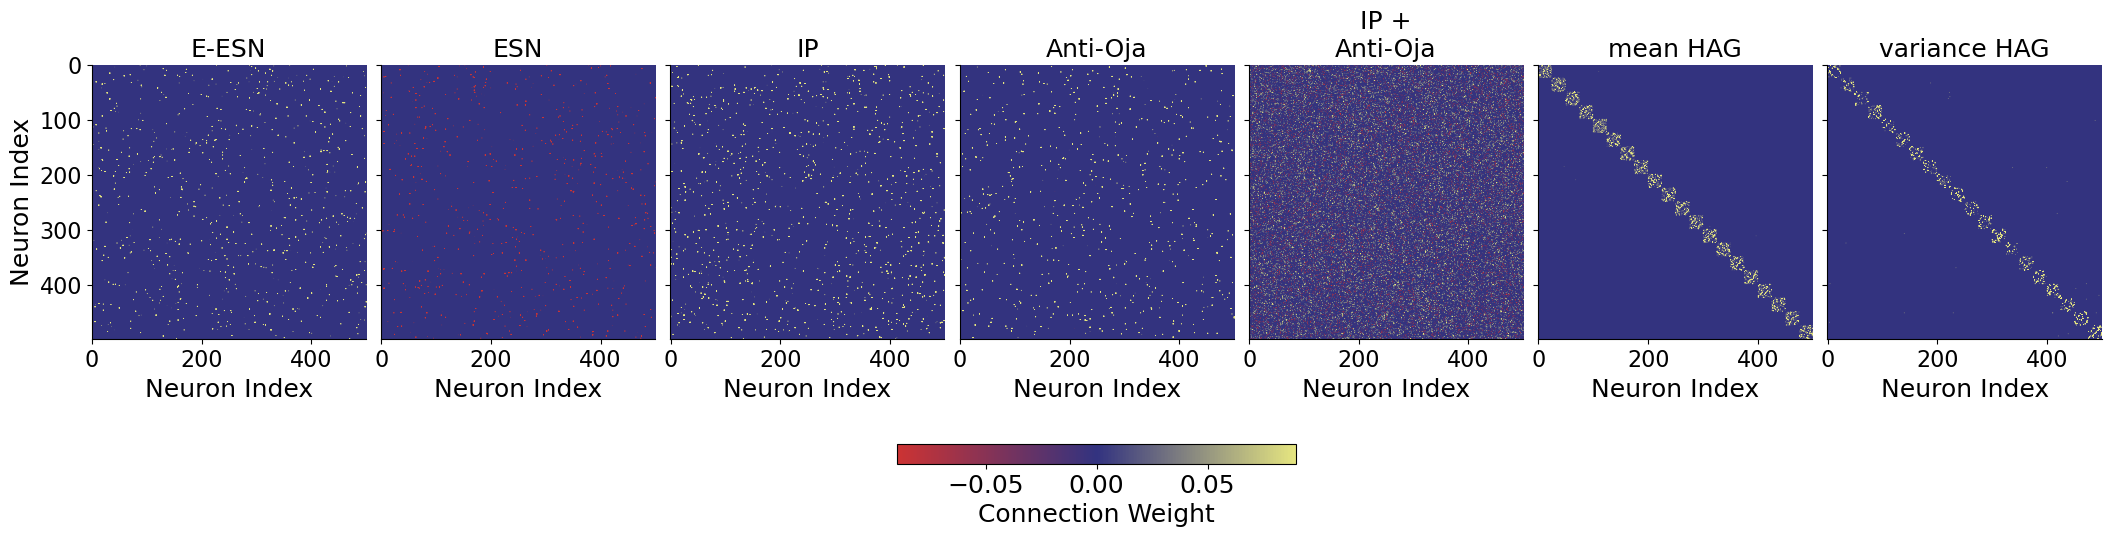

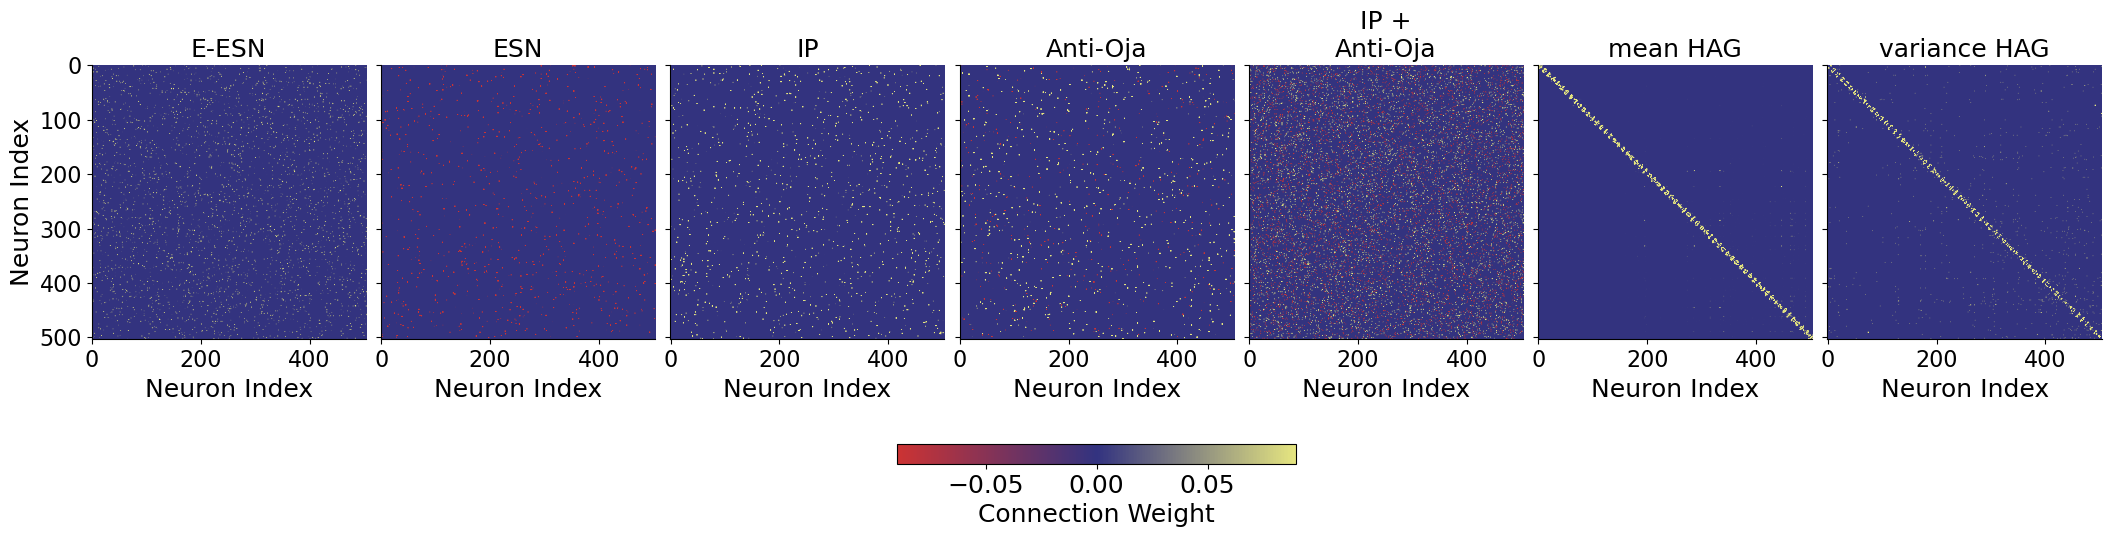

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, TwoSlopeNorm, LinearSegmentedColormap

# Set font sizes
fontsize = 18
title_fontsize = 18  # Title font size for each subplot
tick_labelsize = 16  # Tick label font size

# Create a custom diverging colormap: red for negatives, blue at zero, yellow for positives.
# Example color choices:
# Muted red for negative extreme, calm blue for zero, gentle yellow for positive extreme.
neg_color = (0.8, 0.2, 0.2)   # for negative extreme (-global_vmax)
zero_color = (0.2, 0.2, 0.5)    # darker blue for zero
pos_color = (0.9, 0.9, 0.5)   # for positive extreme (+global_vmax)

# Number of steps on each side (more steps = smoother gradient)
n_steps = 128

# Create two gradients:
# Negative side: from neg_color to zero_color.
neg_cmap = LinearSegmentedColormap.from_list("neg_cmap", [neg_color, zero_color], N=n_steps)
# Positive side: from zero_color to pos_color.
pos_cmap = LinearSegmentedColormap.from_list("pos_cmap", [zero_color, pos_color], N=n_steps)

# Get the color arrays from both halves.
neg_colors = neg_cmap(np.linspace(0, 1, n_steps))
pos_colors = pos_cmap(np.linspace(0, 1, n_steps))

# Combine them into one colormap.
# We want the exact zero value to be represented by our zero_color.
# To ensure a hard cutoff, we force the middle color to zero_color.
combined_colors = np.vstack((neg_colors, pos_colors))
combined_colors[n_steps] = np.array([*zero_color, 1.0])  # force the exact blue at the cutoff

custom_cmap = ListedColormap(combined_colors)

# Define the order of function keys (should match your inner-loop order)
function_keys = ["random_ee", "random_ei", "ip_correct", "anti-oja", "ip-anti-oja", "hadsp", "desp"]
functions_per_dataset = len(function_keys)
titles_display = [function_mapping[key] for key in function_keys]

# Compute a robust global vmax using the 99th percentile across all weight matrices in Ws
all_weights = []
for matrix in Ws:
    if hasattr(matrix, "toarray"):
        matrix = matrix.toarray()
    matrix = np.array(matrix, dtype=float)
    all_weights.extend(matrix.flatten())
global_vmax = np.percentile(np.abs(all_weights), 99)  # use abs here for symmetric limits

# Loop over each dataset (assuming 'datasets' is defined)
for dataset_index, dataset in enumerate(datasets):
    start_idx = dataset_index * functions_per_dataset
    end_idx = (dataset_index + 1) * functions_per_dataset
    Ws_used = Ws[start_idx:end_idx]
    
    fig, axs = plt.subplots(1, len(Ws_used), figsize=(3 * len(Ws_used), 6),
                            constrained_layout=True, sharex=True, sharey=True)
    
    if len(Ws_used) == 1:
        axs = [axs]
    
    # Define norm centered at zero
    norm = TwoSlopeNorm(vmin=-global_vmax, vcenter=0, vmax=global_vmax)
    
    for j, ax in enumerate(axs):
        ax.set_title(titles_display[j], fontsize=title_fontsize)
        if j == 0:
            ax.set_ylabel('Neuron Index', fontsize=fontsize)
        ax.set_xlabel('Neuron Index', fontsize=fontsize)
        ax.tick_params(labelsize=tick_labelsize)
        
        matrix = Ws_used[j]
        if hasattr(matrix, "toarray"):
            matrix = matrix.toarray()
        matrix = np.array(matrix, dtype=float)
        
        if matrix.ndim < 2:
            matrix = np.atleast_2d(matrix)
        
        # Use the raw matrix values without taking the absolute value
        heatmap = ax.imshow(matrix, cmap=custom_cmap, norm=norm)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    cbar = fig.colorbar(heatmap, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Connection Weight', fontsize=fontsize)

    plt.savefig(f'connectivity_matrices_{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()